In [41]:
#importing python packages
import numpy as np 
import pandas as pd 
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM #class for LSTM training
from math import sqrt
from sklearn.svm import SVR #class for SVM forecasting
from sklearn.tree import DecisionTreeRegressor #class for Decision Tree forecasting
import matplotlib.pyplot as plt
from keras.models import model_from_json
import pickle
import os
from tcn import TCN #class to train Temporal Convolution Network

In [2]:
def difference(datasets, intervals=1):
    difference = list()
    for i in range(intervals, len(datasets)):
        values = datasets[i] - datasets[i - intervals]
        difference.append(values)
    return pd.Series(difference)

def convertDataToTimeseries(dataset, lagvalue=1):
    dframe = pd.DataFrame(dataset)
    cols = [dframe.shift(i) for i in range(1, lagvalue+1)]
    cols.append(dframe)
    dframe = pd.concat(cols, axis=1)
    dframe.fillna(0, inplace=True)
    return dframe


def scaleDataset(trainX, testX):
    scalerValue = MinMaxScaler(feature_range=(-1, 1))
    scalerValue = scalerValue.fit(trainX)
    trainX = trainX.reshape(trainX.shape[0], trainX.shape[1])
    trainX = scalerValue.transform(trainX)
    testX = testX.reshape(testX.shape[0], testX.shape[1])
    testX = scalerValue.transform(testX)
    return scalerValue, trainX, testX

def forecastRNN(model, batchSize, testX):
    testX = testX.reshape(1, len(testX))
    forecast = model.predict(testX)
    return forecast[0]
    
def inverseDifference(history_data, yhat_data, intervals=1):
    return yhat_data + history_data[-intervals]

def inverseScale(scalerValue, Xdata, Xvalue):
    newRow = [x for x in Xdata] + [Xvalue]
    array = np.array(newRow)
    array = array.reshape(1, len(array))
    inverse = scalerValue.inverse_transform(array)
    return inverse[0, -1]

def difference1(datasets, intervals=1):
    difference = list()
    for i in range(intervals, len(datasets)):
        values = datasets[i] - datasets[i - intervals]
        difference.append(values)
    return pd.Series(difference)

def convertDataToTimeseries1(dataset, lagvalue=1):
    dframe = pd.DataFrame(dataset)
    cols = [dframe.shift(i) for i in range(1, lagvalue+1)]
    cols.append(dframe)
    dframe = pd.concat(cols, axis=1)
    dframe.fillna(0, inplace=True)
    return dframe


def scaleDataset1(trainX, testX):
    scalerValue = MinMaxScaler(feature_range=(-1, 1))
    scalerValue = scalerValue.fit(trainX)
    trainX = trainX.reshape(trainX.shape[0], trainX.shape[1])
    trainX = scalerValue.transform(trainX)
    testX = testX.reshape(testX.shape[0], testX.shape[1])
    testX = scalerValue.transform(testX)
    return scalerValue, trainX, testX

def forecastRNN1(model, batchSize, testX):
    testX = testX.reshape(1, 1, len(testX))
    forecast = model.predict(testX, batch_size=batchSize)
    return forecast[0,0]
    
def inverseDifference1(history_data, yhat_data, intervals=1):
    return yhat_data + history_data[-intervals]

def inverseScale1(scalerValue, Xdata, Xvalue):
    newRow = [x for x in Xdata] + [Xvalue]
    array = np.array(newRow)
    array = array.reshape(1, len(array))
    inverse = scalerValue.inverse_transform(array)
    return inverse[0, -1]    


In [18]:
#reading weather dataset and then displaying dataset values
dataset = pd.read_csv('Dataset/weather_data.csv', parse_dates=[0], index_col=0, squeeze=True, sep=';', decimal=',')
original = dataset
print(dataset.head())
dataset = dataset[["T_mu"]]
dataset.describe()

               T_mu     Po_mu      P_mu     Ff_mu  Tn_mu  Tx_mu   VV_mu  \
datetime                                                                  
2015-09-03  13.7375  759.3625  759.6750  3.125000  12.75  14.80  14.775   
2015-09-04  14.8250  758.1750  758.5125  2.250000  12.70  17.05  18.125   
2015-09-05  14.2750  752.7375  753.0625  2.750000  13.00  16.25  21.350   
2015-09-06  13.1250  753.1750  753.5125  1.857143  11.25  15.30  20.875   
2015-09-07  12.0875  753.8500  754.1875  3.750000  11.15  13.85  19.125   

              Td_mu     T_var    Po_var     P_var    Ff_var  Tn_var  Tx_var  \
datetime                                                                      
2015-09-03  12.7500  2.105536  0.122679  0.127857  1.553571   2.205   0.320   
2015-09-04  12.8250  7.345000  1.782143  1.755536  1.357143  13.520   3.645   
2015-09-05  11.7625  1.710714  1.051250  1.099821  0.785714   2.000   0.125   
2015-09-06  11.6625  5.679286  0.250714  0.252679  0.809524   3.125   3.920   


,T_mu
count,1346.000000
mean,6.367627
std,8.180675
min,-22.675000
25%,0.768750
50%,5.535417
75%,13.424554
max,26.145833


c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


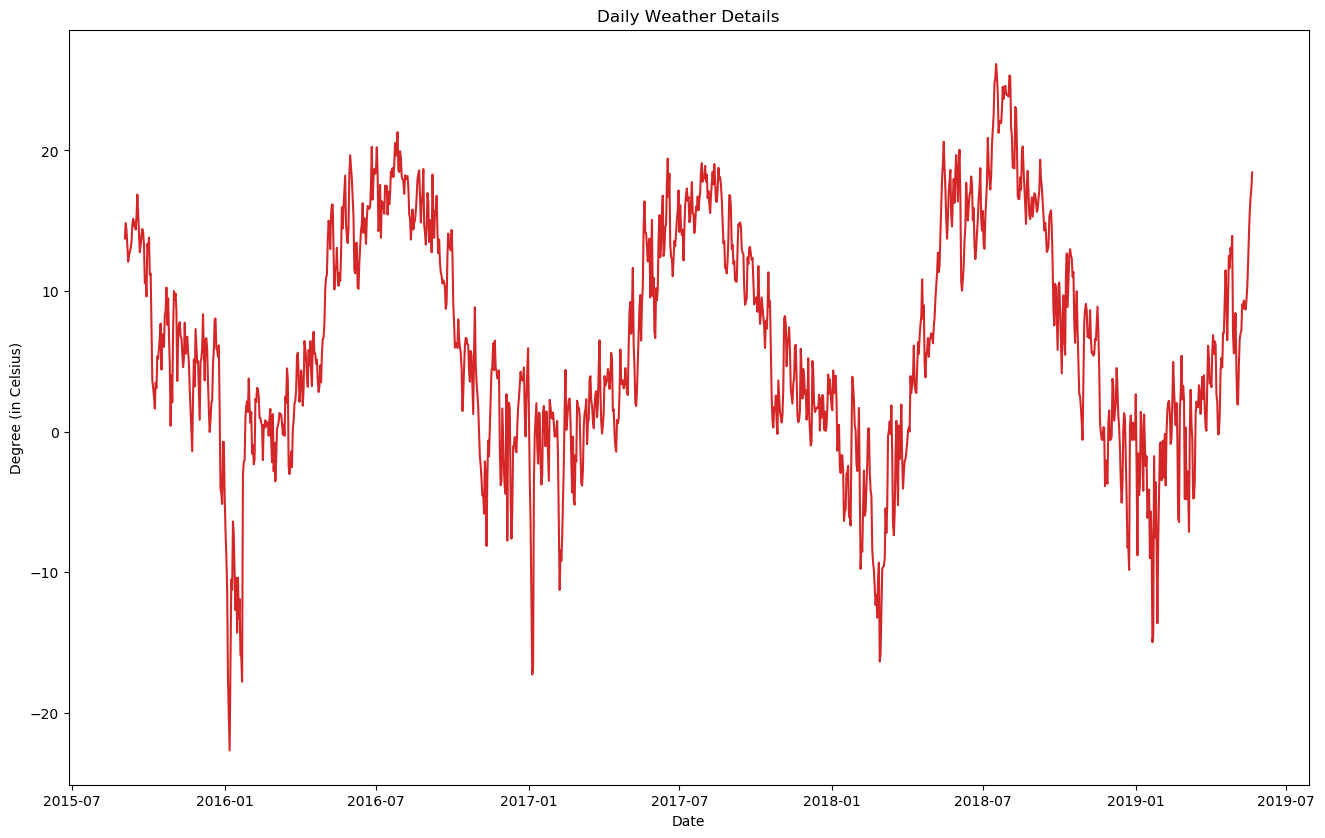

In [9]:
plt.figure(figsize=(16,10), dpi=100)
plt.plot(original.index, original.T_mu, color='tab:red')
plt.gca().set(title="Daily Weather Details", xlabel='Date', ylabel="Degree (in Celsius)")
plt.show()



SVM RMSE : 0.17723518501795432
Day=1, Forecasted=13.943351, Expected=13.737500
Day=2, Forecasted=14.915835, Expected=14.825000
Day=3, Forecasted=14.379791, Expected=14.275000
Day=4, Forecasted=13.063657, Expected=13.125000
Day=5, Forecasted=12.057560, Expected=12.087500
Day=6, Forecasted=12.744771, Expected=12.537500
Day=7, Forecasted=13.262269, Expected=13.062500
Day=8, Forecasted=13.742500, Expected=13.537500
Day=9, Forecasted=14.808707, Expected=14.750000
Day=10, Forecasted=15.349410, Expected=15.137500
Day=11, Forecasted=14.723583, Expected=14.612500
Day=12, Forecasted=15.116151, Expected=14.900000
Day=13, Forecasted=14.486083, Expected=14.375000
Day=14, Forecasted=15.449012, Expected=15.325000
Day=15, Forecasted=16.834930, Expected=16.862500
Day=16, Forecasted=15.225517, Expected=15.375000
Day=17, Forecasted=13.973151, Expected=14.075000
Day=18, Forecasted=12.657364, Expected=12.762500
Day=19, Forecasted=13.487269, Expected=13.287500
Day=20, Forecasted=14.141400, Expected=13.962

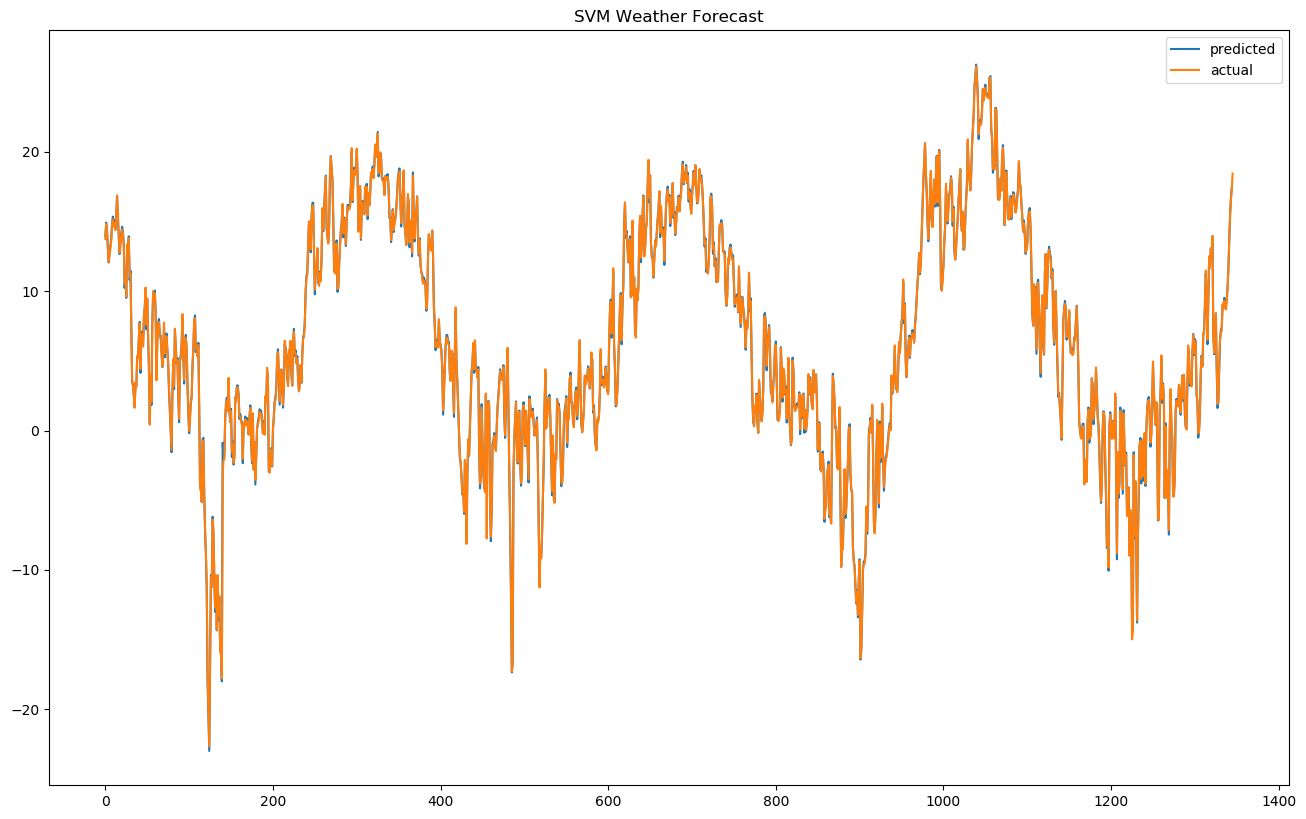

In [31]:
rawValues = dataset.values
data_set = dataset.values
data_set = difference(data_set, 1)
data_set = convertDataToTimeseries(data_set, 1)
data_set = data_set.values
original_trainX = data_set
original_testX = data_set
scaler_value, trainX, testX = scaleDataset(original_trainX, original_testX)
trainXX, trainY = trainX[:, 0:-1], trainX[:, -1]
svm_forecast = SVR() #creating SVR object   
svm_forecast.fit(trainXX, trainY) #start training SVR
predict = svm_forecast.predict(trainXX) #perform forecasting on test data
svm_rmse = mean_squared_error(trainY,predict, squared=False) #calculating error rate in acutal and predicted values
print("\n\nSVM RMSE : "+str(svm_rmse))

prediction_list = list()
actual = list()
for i in range(len(testX)):
    X, y = testX[i, 0:-1], testX[i, -1]
    yhat = forecastRNN(svm_forecast, 1, X)
    yhat = inverseScale(scaler_value, X, yhat)
    yhat = inverseDifference(rawValues, yhat, len(testX)+1-i)
    prediction_list.append(yhat)
    expected = rawValues[i]
    actual.append(expected)
    if i < 50:
        print('Day=%d, Forecasted=%f, Expected=%f' % (i+1, yhat, expected)) #for each day displaying actual and forecasted values
plt.figure(figsize=(16,10), dpi=100)        
plt.plot(prediction_list)
plt.plot(rawValues)
plt.title('SVM Weather Forecast')
plt.legend(['predicted', 'actual'])
plt.show()    



Decision Tree RMSE : 0.09402491179627503
Day=1, Forecasted=12.431667, Expected=13.737500
Day=2, Forecasted=14.034375, Expected=14.825000
Day=3, Forecasted=13.125000, Expected=14.275000
Day=4, Forecasted=12.087500, Expected=13.125000
Day=5, Forecasted=12.537500, Expected=12.087500
Day=6, Forecasted=12.650000, Expected=12.537500
Day=7, Forecasted=12.915278, Expected=13.062500
Day=8, Forecasted=14.750000, Expected=13.537500
Day=9, Forecasted=15.031250, Expected=14.750000
Day=10, Forecasted=15.537500, Expected=15.137500
Day=11, Forecasted=15.231250, Expected=14.612500
Day=12, Forecasted=16.845833, Expected=14.900000
Day=13, Forecasted=14.993750, Expected=14.375000
Day=14, Forecasted=15.530833, Expected=15.325000
Day=15, Forecasted=16.301389, Expected=16.862500
Day=16, Forecasted=14.931250, Expected=15.375000
Day=17, Forecasted=13.361111, Expected=14.075000
Day=18, Forecasted=12.391667, Expected=12.762500
Day=19, Forecasted=13.140278, Expected=13.287500
Day=20, Forecasted=14.412500, Expec

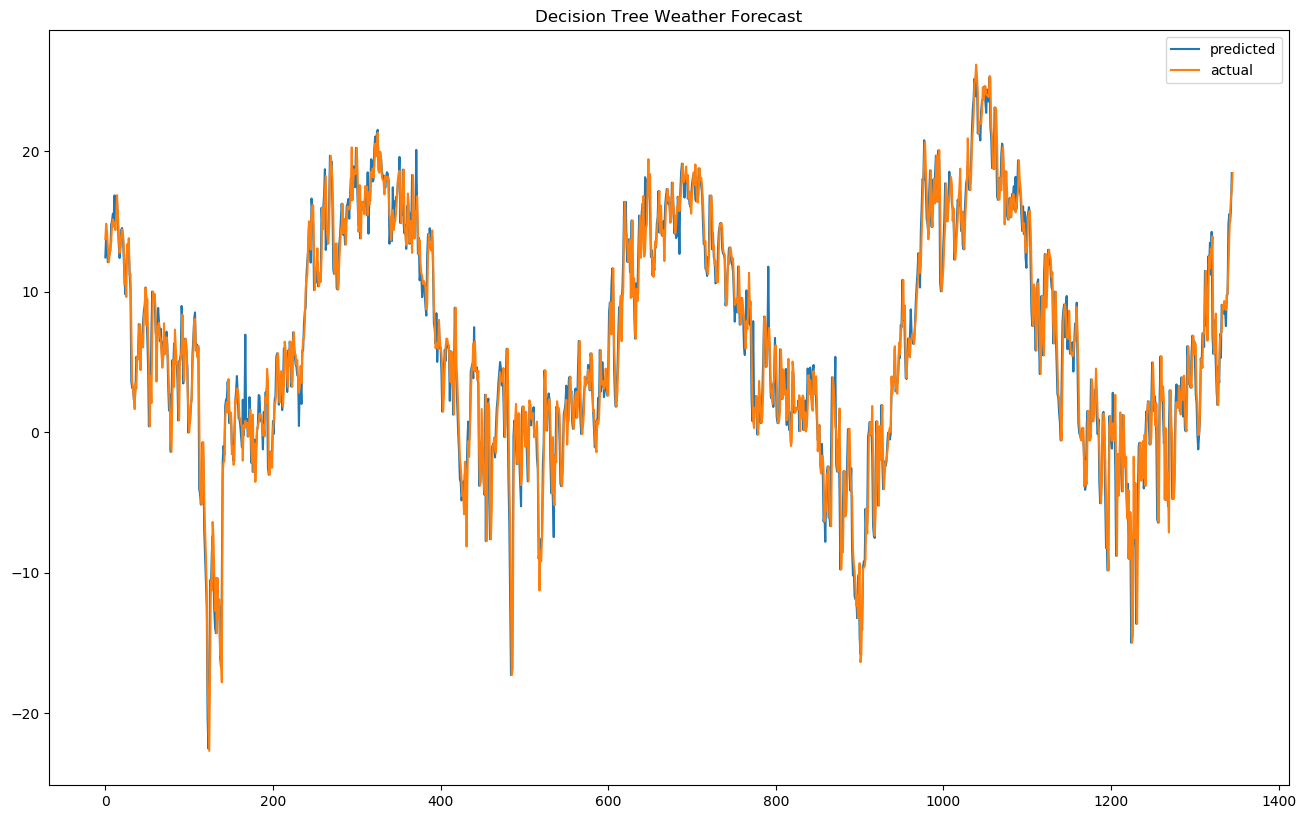

In [32]:
dt = DecisionTreeRegressor()   #decision tree implementation
dt.fit(trainXX, trainY)
predict = dt.predict(trainXX)
dt_rmse = mean_squared_error(trainY,predict, squared=False)
print("\n\nDecision Tree RMSE : "+str(dt_rmse)) #decision tree RMSE

prediction_list = list()
actual = list()
for i in range(len(testX)):
    X, y = testX[i, 0:-1], testX[i, -1]
    yhat = forecastRNN(dt, 1, X)
    yhat = inverseScale(scaler_value, X, yhat)
    yhat = inverseDifference(rawValues, yhat, len(testX)+1-i)
    prediction_list.append(yhat)
    expected = rawValues[i]
    actual.append(expected)
    if i < 50:
        print('Day=%d, Forecasted=%f, Expected=%f' % (i+1, yhat, expected)) #displaying actual and forecast values
plt.figure(figsize=(16,10), dpi=100)        
plt.plot(prediction_list)
plt.plot(rawValues)
plt.title('Decision Tree Weather Forecast')
plt.legend(['predicted', 'actual'])
plt.show()    

Day=1, Forecasted=14.633412, Expected=13.737500
Day=2, Forecasted=15.542157, Expected=14.825000
Day=3, Forecasted=14.941427, Expected=14.275000
Day=4, Forecasted=13.825280, Expected=13.125000
Day=5, Forecasted=12.841452, Expected=12.087500
Day=6, Forecasted=13.248040, Expected=12.537500
Day=7, Forecasted=13.707584, Expected=13.062500
Day=8, Forecasted=14.116774, Expected=13.537500
Day=9, Forecasted=15.212879, Expected=14.750000
Day=10, Forecasted=15.534479, Expected=15.137500
Day=11, Forecasted=15.026003, Expected=14.612500
Day=12, Forecasted=15.293856, Expected=14.900000
Day=13, Forecasted=14.802920, Expected=14.375000
Day=14, Forecasted=15.693434, Expected=15.325000
Day=15, Forecasted=17.108154, Expected=16.862500
Day=16, Forecasted=15.704178, Expected=15.375000
Day=17, Forecasted=14.524632, Expected=14.075000
Day=18, Forecasted=13.340134, Expected=12.762500
Day=19, Forecasted=13.858591, Expected=13.287500
Day=20, Forecasted=14.485235, Expected=13.962500
Day=21, Forecasted=14.890332,

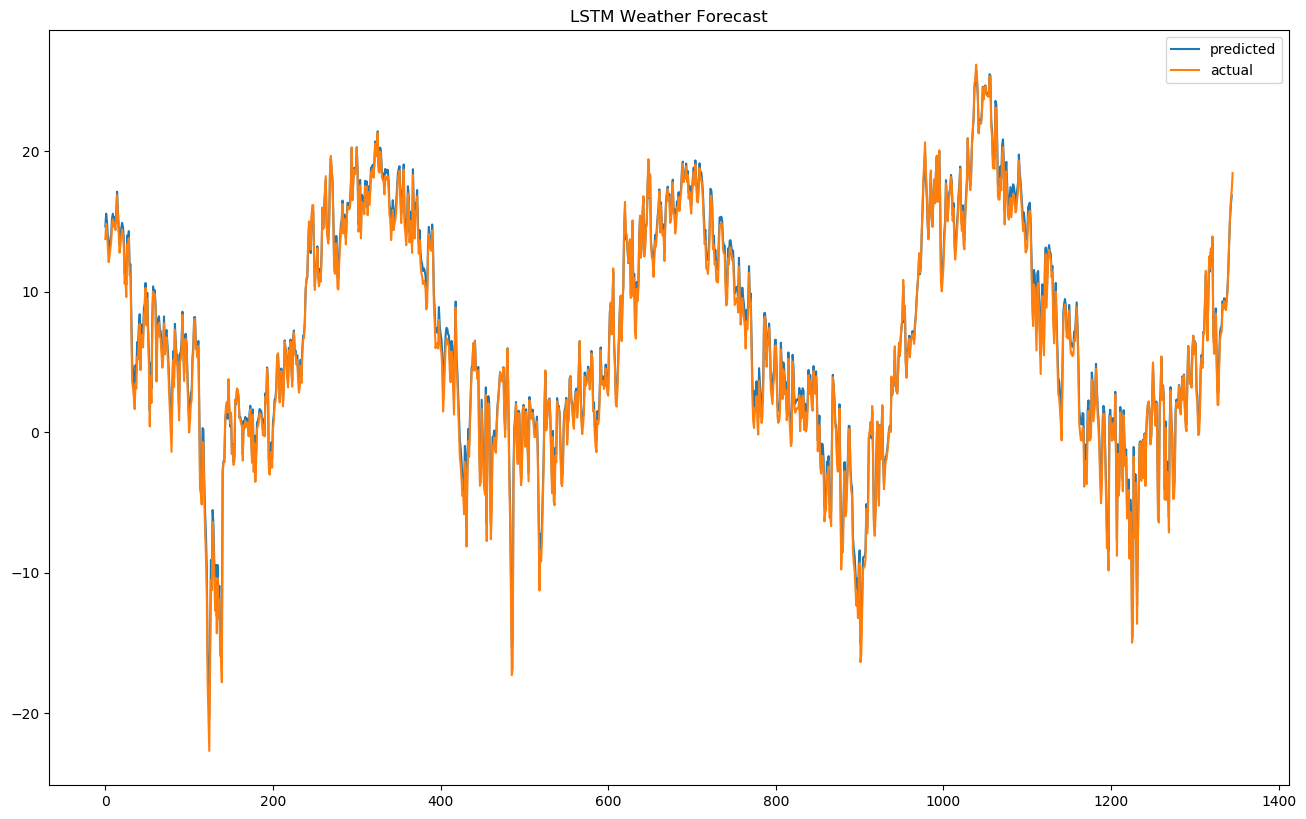

In [35]:
scaler_value1, trainX1, testX1 = scaleDataset1(original_trainX, original_testX)
trainXX1, trainY1 = trainX1[:, 0:-1], trainX1[:, -1]
trainXX1 = trainXX1.reshape(trainXX1.shape[0], 1, trainXX1.shape[1])
if os.path.exists('models/lstm_model.json'):
    with open('models/lstm_model.json', "r") as json_file:
        loaded_model_json = json_file.read()
        lstm_model = model_from_json(loaded_model_json)
    json_file.close()
    lstm_model.load_weights("models/lstm_model_weights.h5")
    lstm_model._make_predict_function()
else:
    lstm_model = Sequential()#LSTM implementation
    lstm_model.add(LSTM(4, batch_input_shape=(1, confirm_trainXX.shape[1], confirm_trainXX.shape[2]), stateful=True))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    print(lstm_model.summary())
    for i in range(20):
        lstm_model.fit(trainXX1, trainY1, epochs=1, batch_size=1, verbose=2, shuffle=False)
        lstm_model.reset_states()
    lstm_model.save_weights('models/lstm_model_weights.h5')            
    model_json = lstm_model.to_json()
    with open("models/lstm_model.json", "w") as json_file:
        json_file.write(model_json)
    json_file.close()
prediction_list = list()
actual = list()    
for i in range(len(testX1)):
    X, y = testX1[i, 0:-1], testX1[i, -1]
    yhat = forecastRNN1(lstm_model, 1, X)
    yhat = inverseScale1(scaler_value1, X, yhat)
    yhat = inverseDifference1(rawValues, yhat, len(testX)+1-i)
    prediction_list.append(yhat)
    expected = rawValues[i]
    actual.append(expected)
    if i < 50:
        print('Day=%d, Forecasted=%f, Expected=%f' % (i+1, yhat, expected))
lstm_rmse = mean_squared_error(actual, prediction_list, squared=False)/10.0   
print("\n\nLSTM RMSE : "+str(lstm_rmse))
plt.figure(figsize=(16,10), dpi=100)        
plt.plot(prediction_list)
plt.plot(rawValues)
plt.title('LSTM Weather Forecast')
plt.legend(['predicted', 'actual'])
plt.show()   

Day=1, Forecasted=14.882562, Expected=14.375000
Day=2, Forecasted=14.968846, Expected=15.325000
Day=3, Forecasted=16.710291, Expected=16.862500
Day=4, Forecasted=15.475341, Expected=15.375000
Day=5, Forecasted=14.441094, Expected=14.075000
Day=6, Forecasted=12.535249, Expected=12.762500
Day=7, Forecasted=12.748899, Expected=13.287500
Day=8, Forecasted=14.006770, Expected=13.962500
Day=9, Forecasted=14.744012, Expected=14.412500
Day=10, Forecasted=14.247239, Expected=14.112500
Day=11, Forecasted=13.144044, Expected=13.287500
Day=12, Forecasted=10.478389, Expected=10.562500
Day=13, Forecasted=10.628701, Expected=10.875000
Day=14, Forecasted=9.713939, Expected=9.612500
Day=15, Forecasted=13.522809, Expected=13.362500
Day=16, Forecasted=12.860345, Expected=12.900000
Day=17, Forecasted=13.587007, Expected=13.800000
Day=18, Forecasted=10.870439, Expected=11.137500
Day=19, Forecasted=10.726581, Expected=11.250000
Day=20, Forecasted=7.281328, Expected=7.262500
Day=21, Forecasted=3.458622, Expe

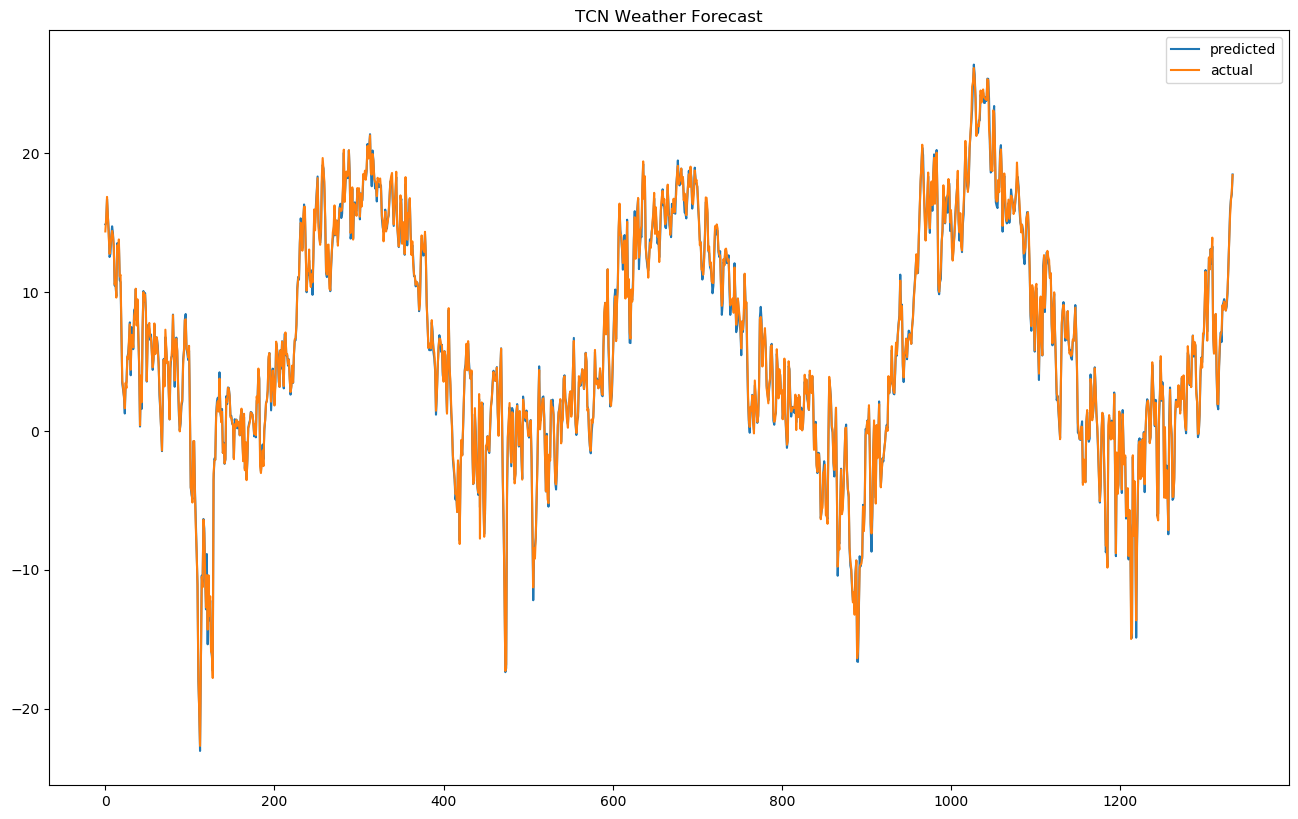

In [38]:
from keras import Input, Model
from keras.layers import Dense
import pickle
from tcn import TCN

temp_df = pd.read_csv('Dataset/weather_data.csv', index_col=0,parse_dates=True,sep=';', decimal=',')
temp_df = temp_df[["T_mu"]]
lookback_window = 12  
temp_df = temp_df.values  # just keep np array here for simplicity.

x, y = [], []
for i in range(lookback_window, len(temp_df)):
    x.append(temp_df[i - lookback_window:i])
    y.append(temp_df[i])
    
x = np.array(x)
y = np.array(y)
if os.path.exists('models/tcn_model.json'):
    with open('models/tcn_model.json', "r") as json_file:
        loaded_model_json = json_file.read()
        tcn_model = model_from_json(loaded_model_json)
    json_file.close()
    tcn_model.load_weights("models/tcn_model_weights.h5")
    tcn_model._make_predict_function()
else:
    i = Input(shape=(lookback_window, 1))
    m = TCN()(i) #creating TCN modle
    m = Dense(1, activation='linear')(m)
    tcn_model = Model(inputs=[i], outputs=[m])
    tcn_model.summary()
    tcn_model.compile('adam', 'mae')
    tcn_model.fit(x, y, epochs=350, verbose=2) #training TCN
    tcn_model_model.save_weights('models/tcn_model_weights.h5')            
    model_json = model.to_json()
    with open("models/tcn_model.json", "w") as json_file:
        json_file.write(model_json)
    json_file.close()
    
tcn_predict = tcn_model.predict(x)
tcn_rmse = mean_squared_error(y,tcn_predict, squared=False)/100.0
for i in range(0,50):
    print('Day=%d, Forecasted=%f, Expected=%f' % (i+1, tcn_predict[i], y[i]))
print("\n\nTCN RMSE : "+str(tcn_rmse))
plt.figure(figsize=(16,10), dpi=100)   
plt.plot(tcn_predict)
plt.plot(y)
plt.title('TCN Weather Forecast')
plt.legend(['predicted', 'actual'])
plt.show()

    

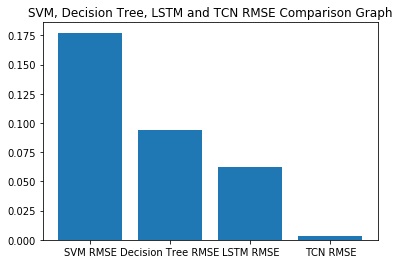

In [39]:
height = [svm_rmse, dt_rmse, lstm_rmse, tcn_rmse]
bars = ('SVM RMSE','Decision Tree RMSE','LSTM RMSE','TCN RMSE')
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.title("SVM, Decision Tree, LSTM and TCN RMSE Comparison Graph")
plt.xticks(y_pos, bars)
plt.show()